# AllLife Credit Card Customer Segmentation

## Background
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

## Objective
To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

## Key Questions
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?

## Data Description
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

(this notebook loaded to GitHub at https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-may20-pierssmith/tree/master/Week%2016%20-%20Project%20-%20Unsupervised%20Learning)

#  
---
# 1 - Import libraries and load dataset
---

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.stats import zscore
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import cdist, pdist

sns.reset_orig()

In [2]:
df_abt_CustomerData = pd.read_excel('Credit Card Customer Data.xlsx')

In [3]:
df_abt_CustomerData.head()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0                  1                    1                 0  
1                  0                   10                 9  
2                  1                    3                 4  
3                  1                    1                 4  
4                  0                   12                 3

In [4]:
df_abt_CustomerData.tail()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
655    656         51108             99000                  10   
656    657         60732             84000                  10   
657    658         53834            145000                   8   
658    659         80655            172000                  10   
659    660         80150            167000                   9   

     Total_visits_bank  Total_visits_online  Total_calls_made  
655                  1                   10                 0  
656                  1                   13                 2  
657                  1                    9                 1  
658                  1                   15                 0  
659                  0                   12                 2

In [5]:
df_abt_CustomerData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


#### Data load summary

The dataset contains 660 observations. There are 7 columns, all loaded as numeric (integer), and no null values.

#  
---
# 2 - Deliverables
---

---
# Deliverable 1 (exploratory data analysis report)
---

 ---
## Deliverable 1.1 - Univariate analysis

*(Requirement 1. Perform univariate analysis on the data to better understand the variables at your
disposal and to get an idea about the no of clusters. Perform EDA, create visualizations to explore data.)*

*(Requirement 2. Properly comment on the codes, provide explanations of the steps taken in the
notebook and conclude your insights from the graphs.)*

### Profiling Report

In [6]:
pandas_profiling.ProfileReport(df_abt_CustomerData)

The project brief describes five data points for each record
* credit limit (Avg_Credit_Limit); 
* total number of credit cards (Total_Credit_Cards), and three contact channels; 
* bank branch visits (Total_visits_bank);
* online (Total_visits_online); and
* call centre (Total_calls_made)

There are two additional columns;
1. Sl_No - this is an index, as there are 660 unique values, in the range 1 to 660
2. Customer Key - this appears to be a unique identifer. Of note is that there are 655 unique values instead of 660, so this would suggest at least one customer has been sampled more than once. No duplicate records have been found however, so this suggests the customers may have been sampled over a period of time, in which case the movements in individual customer data in terms of credit usage and contact are still relevant. All the data will be kept.

In [7]:
df_abt_CustomerData.drop(['Sl_No', 'Customer Key'], axis=1, inplace=True)

In [8]:
df_abt_CustomerData.describe().transpose()

count          mean           std     min      25%  \
Avg_Credit_Limit     660.0  34574.242424  37625.487804  3000.0  10000.0   
Total_Credit_Cards   660.0      4.706061      2.167835     1.0      3.0   
Total_visits_bank    660.0      2.403030      1.631813     0.0      1.0   
Total_visits_online  660.0      2.606061      2.935724     0.0      1.0   
Total_calls_made     660.0      3.583333      2.865317     0.0      1.0   

                         50%      75%       max  
Avg_Credit_Limit     18000.0  48000.0  200000.0  
Total_Credit_Cards       5.0      6.0      10.0  
Total_visits_bank        2.0      4.0       5.0  
Total_visits_online      2.0      4.0      15.0  
Total_calls_made         3.0      5.0      10.0

### Variable analysis

There are no duplicate rows in the profiling report, and no missing values as noted above, so there are no imputation or duplicate removal steps required.

#### Avg_Credit_Limit
Avg_Credit_Limit (integer) - the customer's credit limit. The name of variable as 'average' suggests customers in the sample hold more than one product. The data is in the range \\$3000 to \\$200000, and there are no zeroes and no nulls. The range appears reasonable for credit limits. The median is \\$18000 wit a mean of \\$34574, the distribution is heavily right skewed (skewness 2.202) as can be observed in the distribution and box plots. This variable is the only data point where the unit is dollars, as the other variables are all counts as described in the project brief (credit cards and channel contracts), so scaling will be used before the cluster analysis.

In [9]:
df_abt_CustomerData['Avg_Credit_Limit'].describe()

count       660.000000
mean      34574.242424
std       37625.487804
min        3000.000000
25%       10000.000000
50%       18000.000000
75%       48000.000000
max      200000.000000
Name: Avg_Credit_Limit, dtype: float64

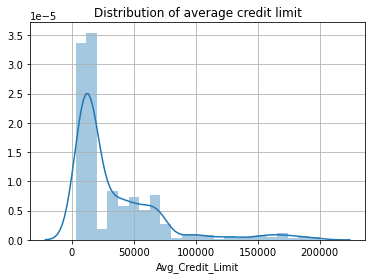

In [10]:
g1 = sns.distplot(df_abt_CustomerData['Avg_Credit_Limit'])
g1.grid()
g1.set(title='Distribution of average credit limit')
plt.show()

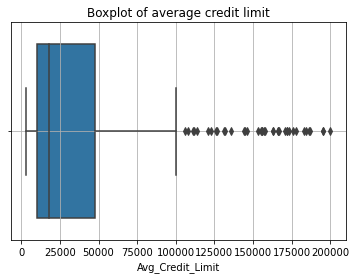

In [11]:
g1 = sns.boxplot(df_abt_CustomerData['Avg_Credit_Limit'])
g1.grid()
g1.set(title='Boxplot of average credit limit')
plt.show()

The boxplot shows many datapoints outside the whiskers due to the right skew of the distribution. Dropping the outliers would result in a significant loss of information for this analysis, and because the purpose of this analysis is to examine clustering and the units for the variables are different, zscore scaling will be the strategy for this analysis.

#### Total_Credit_Cards
Total_Credit_Cards (integer) - total number of cards. This variable gives the context for 'average' credit limit in previous variable - this sample of customers all hold at least one credit card. Correspondingly, the data is in the range 1 to 10, and there are no missing values and no zeroes. The maximum value is of note - 10 credit cards seems very high, however there are 19 observations with this value, and each value from 1 to 10 is represented, so this does not appear to be an error. The median is 5, and the mean 4.7, and the distribution appears quite normal. Again, this data is on a unique scale, counting the number of a particular product, so the scaling strategy will be used.

In [12]:
df_abt_CustomerData['Total_Credit_Cards'].describe()

count    660.000000
mean       4.706061
std        2.167835
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       10.000000
Name: Total_Credit_Cards, dtype: float64

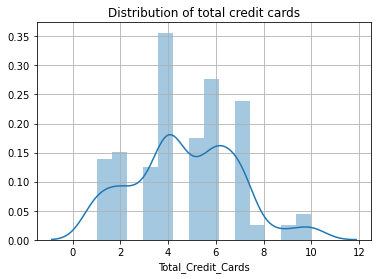

In [13]:
g1 = sns.distplot(df_abt_CustomerData['Total_Credit_Cards'])
g1.grid()
g1.set(title='Distribution of total credit cards')
plt.show()

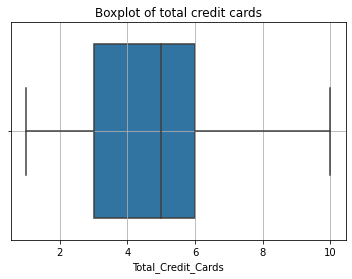

In [14]:
g1 = sns.boxplot(df_abt_CustomerData['Total_Credit_Cards'])
g1.grid()
g1.set(title='Boxplot of total credit cards')
plt.show()

#### Total_visits_bank
Total_visits_bank (integer) - number of times the customer visited the bank. In the context of the other channels as described in the project brief, this appears to refer to a face-to-face contact in a branch. The range is 0 to 5, with 100 (15.2%) zeroes - in the context of this being the usage count of a particular channel, this suggests many customers don't visit in person. The time period for sampling of this data is unknown, but given two other channel options are captured in this data, and considering contemporary assumptions about customer behaviour, the number of 0 observations does not seem unreasonable. The median is 2, and the mean 2.4, and the distribution normal.

In [15]:
df_abt_CustomerData['Total_visits_bank'].describe()

count    660.000000
mean       2.403030
std        1.631813
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        5.000000
Name: Total_visits_bank, dtype: float64

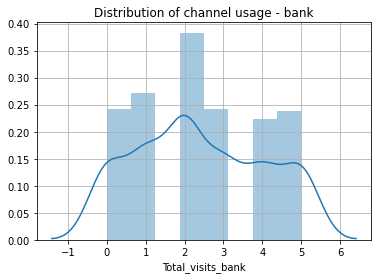

In [16]:
g1 = sns.distplot(df_abt_CustomerData['Total_visits_bank'])
g1.grid()
g1.set(title='Distribution of channel usage - bank')
plt.show()

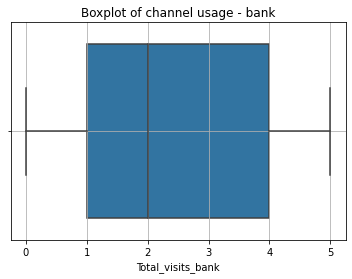

In [17]:
g1 = sns.boxplot(df_abt_CustomerData['Total_visits_bank'])
g1.grid()
g1.set(title='Boxplot of channel usage - bank')
plt.show()

#### Total_visits_online
Total_visits_online (integer) - number of times the customer has contacted the bank online. The data is in the range 0 to 15, with 144 (21.8%) zeroes, suggesting many customers don't contact online. This is interesting, and in an actual customer engagement it would be interesting to collect additional demographic data to see if there are other factors that might influence channel choice. The range appears reasonable however, given there are a few barriers to online access and the demographic and time period for observations are unknown. The median is 2 and the mean 2.6, and the distribution is heavily right skewed (skewness 2.226), suggesting there are some outlying customers who make extensive use of this channel. Again, scaling is the strategy for this analysis.

In [18]:
df_abt_CustomerData['Total_visits_online'].describe()

count    660.000000
mean       2.606061
std        2.935724
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       15.000000
Name: Total_visits_online, dtype: float64

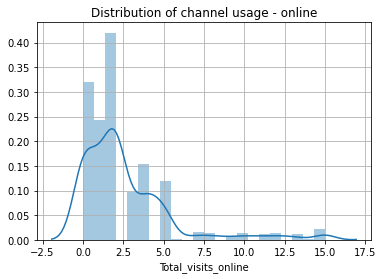

In [19]:
g1 = sns.distplot(df_abt_CustomerData['Total_visits_online'])
g1.grid()
g1.set(title='Distribution of channel usage - online')
plt.show()

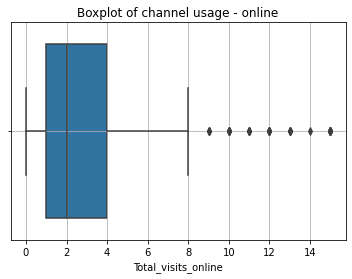

In [20]:
g1 = sns.boxplot(df_abt_CustomerData['Total_visits_online'])
g1.grid()
g1.set(title='Boxplot of channel usage - online')
plt.show()

#### Total_calls_made
Total_calls_made (integer) - number of times the customer contacted the bank via the call centre. 
The data is in the range 0 to 10, with 97 (14.7%) zeroes, so this is broadly consistent with the pattern in the other two channels, both in terms of the range and the percentage of customers who don't use the channel. As such, the range is reasonable. The median is 3, and the mean 3.6, and the data has a moderate right skew.

In [21]:
df_abt_CustomerData['Total_calls_made'].describe()

count    660.000000
mean       3.583333
std        2.865317
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       10.000000
Name: Total_calls_made, dtype: float64

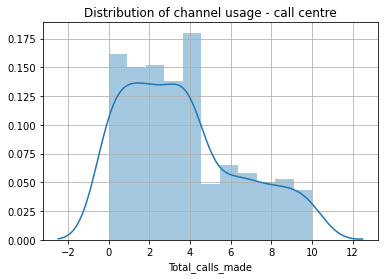

In [22]:
g1 = sns.distplot(df_abt_CustomerData['Total_calls_made'])
g1.grid()
g1.set(title='Distribution of channel usage - call centre')
plt.show()

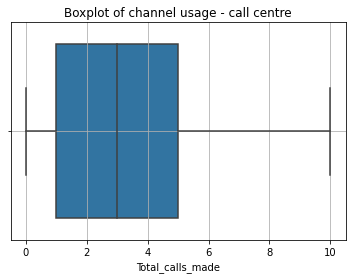

In [23]:
g1 = sns.boxplot(df_abt_CustomerData['Total_calls_made'])
g1.grid()
g1.set(title='Boxplot of channel usage - call centre')
plt.show()

##  
---
## Deliverable 1.2 - Bivariate analysis

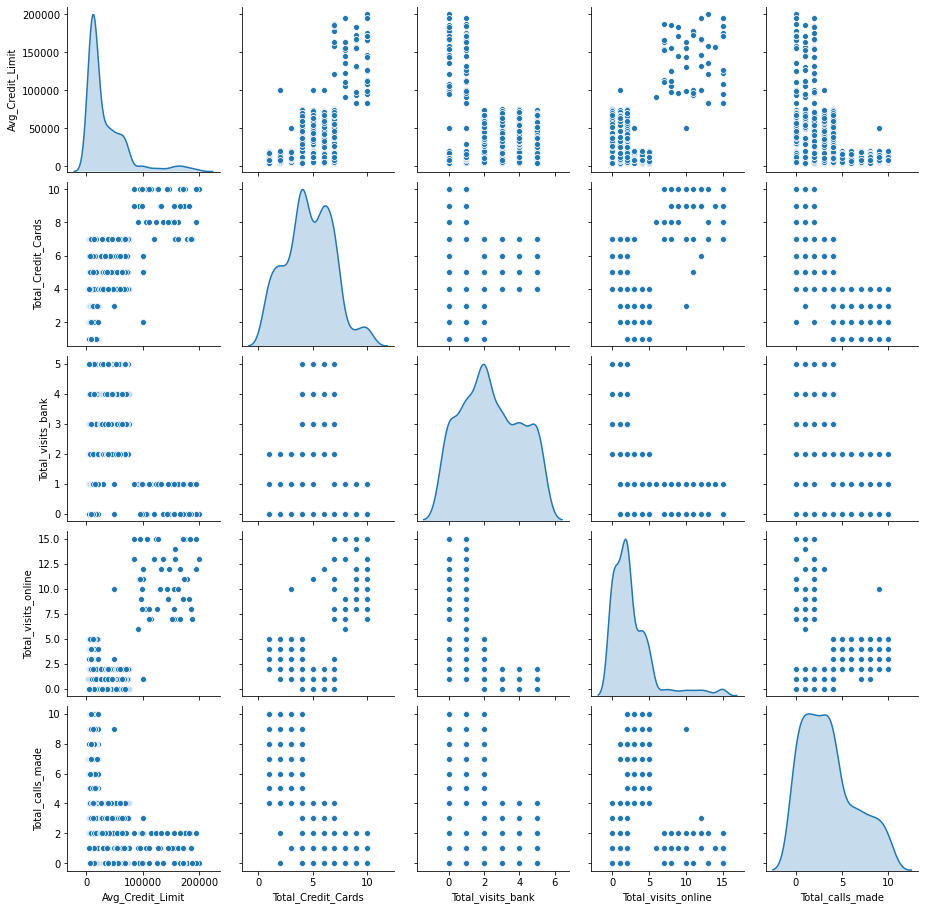

In [24]:
sns.pairplot(df_abt_CustomerData, diag_kind='kde');

The observation of the distribution plots together suggest a consistent pattern of around 3-4 potential clusters.
* Avg_Credit_Limit - suggests 3 clusters
* Total_Credit_Cards - suggests 4 clusters
* Total_visits_bank - suggests 3-4 clusters
* Total_visits_online - suggests 3-4 clusters
* Total_calls_made - suggests 2-3 clusters

In terms of the off-diagonal analysis, there are some relationships apparent in the channel choices.
* higher visits to bank are negatively correlated with online and calls
* higher visits online negatively correlated with calls although there are outliers

This suggests the customers in this cohort who have higher rates of usage of online banking make fewer trips to the branch, and fewer calls. That is, they make more use of self-service channels, and this will be interesting to consider later in the context of the bank's objective to upgrade the service model and ensure queries are resolved faster. If customers who use the other channels can be encouraged to use self-service, that would seem to be a good strategy to resolve query resolution times, and save channel servicing costs at the same time.

Conversely, the customers in this cohort who prefer the branch don't use online or call centre channels as much, so this cohort has a high servicing cost and are likely to be correlated with the group who perceive service response time poorly.

This same pattern also suggests customers have a preferred channel, which is why all the channels are negatively correlated with each other. This again suggests a strategy to resolve servicing times would be to target customers using the branch and call centre channels and move them to self-service.

The relationships between average credit limit and channel usage are also of note. There is a strong positive correlation between higher average credit limits and the use of the online channel, and a negative correlation with the branch and call centre. This suggests customers with higher limits (and presumably higher incomes to service them) make greater use of self-service channels than people with lower limits - again, this is useful insight in the context of the business objectives to improve servicing times. Unsurprisingly, there is a linear relationship apparent between average credit limit and the number of credit cards.

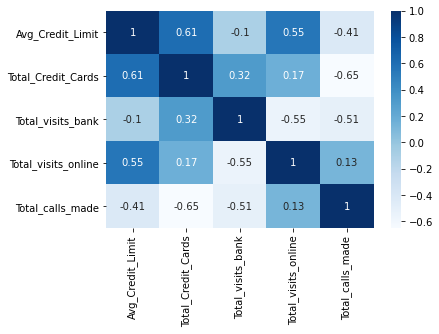

In [25]:
corr = df_abt_CustomerData.corr() 
sns.heatmap(corr, annot=True, cmap='Blues');

The correlation matrix reflects the insights from the pair plot.

* Average Credit Limit - positive correlation with total cards and total online visits, negative with total calls made
* Total Credit Cards - positive correlation with credit limit and total visits to the bank, negative with total calls made
* Total visits bank - negative correlation with total visits online and total calls made
* Total visits online - positive correlation with credit limit, negative to visits bank
* Total calls made - negative correlation with credit limit, and both the other channels

---
# Deliverable 2 (cluster analysis)
---

Before starting the cluster analysis, create a new dataset for analysis which is scaled using zscore.

In [26]:
df_set_ScaledCustomerData = df_abt_CustomerData.apply(zscore)

In [27]:
df_set_ScaledCustomerData.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0          1.740187           -1.249225          -0.860451   
1          0.410293           -0.787585          -1.473731   
2          0.410293            1.058973          -0.860451   
3         -0.121665            0.135694          -0.860451   
4          1.740187            0.597334          -1.473731   

   Total_visits_online  Total_calls_made  
0            -0.547490         -1.251537  
1             2.520519          1.891859  
2             0.134290          0.145528  
3            -0.547490          0.145528  
4             3.202298         -0.203739

##  
---
## Deliverable 2.1 - K-means clustering

*(Requirement 3. Execute K-means clustering use elbow plot and analyse clusters using boxplot)*


In [28]:
# Create working copies of the analysis base table (abt) and scaled data
df_working_CustomerData = df_abt_CustomerData.copy()
df_working_ScaledCustomerData = df_set_ScaledCustomerData.copy()

### Elbow plot

Create an elbow plot to examine some candidate values for k.

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

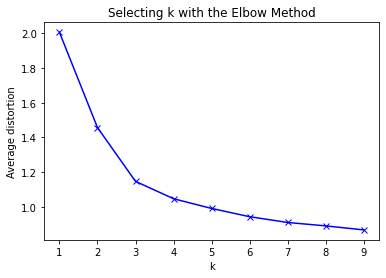

In [29]:
clusters=range(1,10)
avg_distortions=[]

for i in clusters:
    mod_KMeans = KMeans(n_clusters=i, random_state=96)
    mod_KMeans.fit(df_working_ScaledCustomerData)
    avg_distortions.append(sum(np.min(cdist(df_working_ScaledCustomerData, mod_KMeans.cluster_centers_, 'euclidean'), axis=1)) / df_working_ScaledCustomerData.shape[0])


plt.plot(clusters, avg_distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

#### Observations

There is a pronounced elbow at where k is equal to 3, and another slight elbow where k is equal to 4. This would appear to be consistent with the observations in the bivariate analysis above. As there are two candidates, the strategy for this analysis will be to do two rounds of KMeans using both values for k, and compare the results.

### Round 1 - three clusters (k=3)

In [30]:
mod_KMeans_k3 = KMeans(n_clusters=3, random_state=96)
mod_KMeans_k3.fit(df_working_ScaledCustomerData)

pred_KMeans_k3 = mod_KMeans_k3.predict(df_working_ScaledCustomerData)
df_working_CustomerData["Group"] = pred_KMeans_k3

df_set_KMeansCustomerData_k3 = df_working_CustomerData.groupby(['Group'])
df_set_KMeansCustomerData_k3.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Group                                                            
0          33782.383420            5.515544           3.489637   
1          12174.107143            2.410714           0.933036   
2         141040.000000            8.740000           0.600000   

       Total_visits_online  Total_calls_made  
Group                                         
0                 0.981865          2.000000  
1                 3.553571          6.870536  
2                10.900000          1.080000

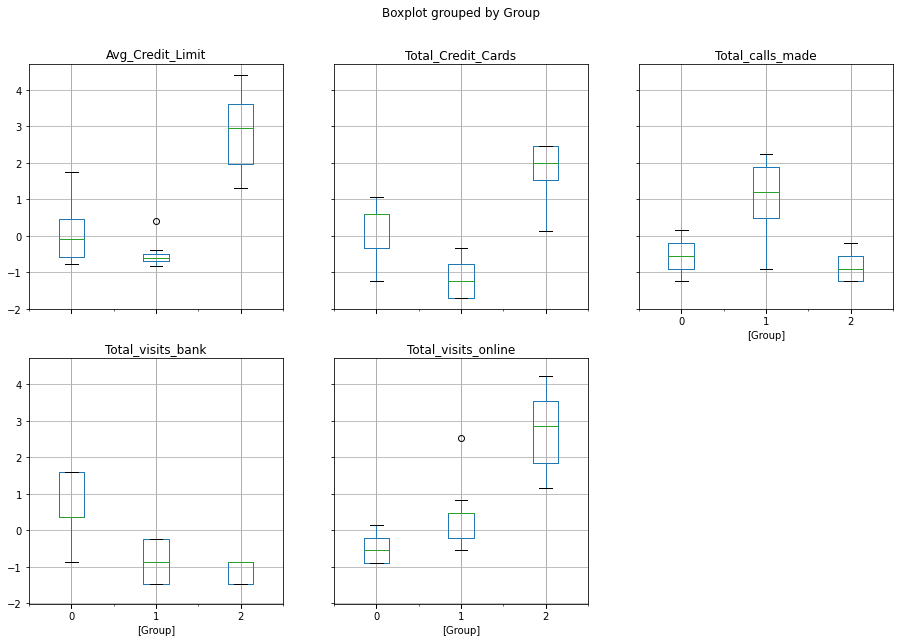

In [31]:
df_working_ScaledCustomerData["Group"] = pred_KMeans_k3
df_working_ScaledCustomerData.boxplot(by='Group', layout = (2,3),figsize=(15,10));

### Round 2 - four clusters (k=4)

In [32]:
mod_KMeans_k4 = KMeans(n_clusters=4, random_state=96)
mod_KMeans_k4.fit(df_working_ScaledCustomerData)

pred_KMeans_k4 = mod_KMeans_k4.predict(df_working_ScaledCustomerData)
df_working_CustomerData["Group"] = pred_KMeans_k4

df_set_KMeansCustomerData_k4 = df_working_CustomerData.groupby(['Group'])
df_set_KMeansCustomerData_k4.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Group                                                            
0         141040.000000            8.740000           0.600000   
1          31226.315789            5.478947           4.515789   
2          12161.434978            2.408072           0.937220   
3          36152.284264            5.538071           2.482234   

       Total_visits_online  Total_calls_made  
Group                                         
0                10.900000          1.080000  
1                 1.010526          1.936842  
2                 3.565022          6.896861  
3                 0.954315          2.055838

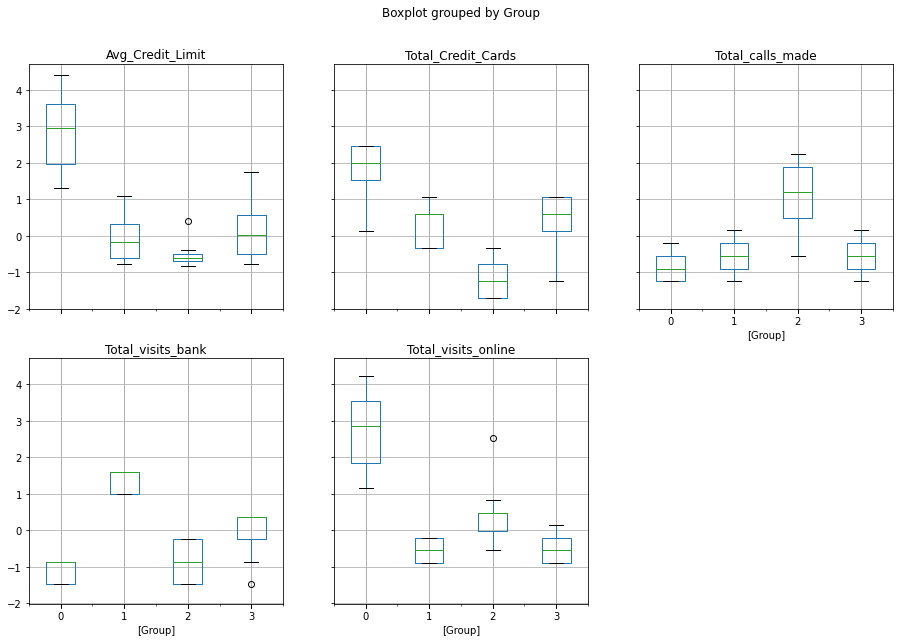

In [33]:
df_working_ScaledCustomerData["Group"] = pred_KMeans_k4
df_working_ScaledCustomerData.boxplot(by='Group', layout = (2,3),figsize=(15,10));

#### Observations

Using k of 4 has not improved the clustering, when evaluated in the context of the business problem. The clusters with the high and low average credit limits have barely changed (the cluster with the highest average credit limit is identical whether k is 3 or 4, and the cluster with the lowest average credit limit only varies by $10 whether k is 3 or 4, and fractional changes in channel usage). 

All that has been achieved with k of 4 is splitting the middle group, and not in a useful way. The boxplots show that the average credit limits almost completely overlap, and the boxplots also show the only point of differentiation appears to be the number of visits made to the bank. However, visits to be bank already differentiates this cluster when k is 3 as can be seen in the first set of boxplots, and given the objective of the bank is to improve servicing times (which would mean targeting channels like in-person visits), splitting this cluster offers no value. k of 3 is the best result.

### Silhouette Scores

In [34]:
# Reset the working copy of the scaled customer data to drop the group column
df_working_ScaledCustomerData = df_set_ScaledCustomerData.copy()

# Create a dataframe to hold the score results
df_KMeansSilhouettes = pd.DataFrame(columns=['k', 'silhouette'])

# Will try the two candidates for k tested above, and the k either side
n_clusters = [2, 3, 4, 5]

i = 0
for n_cluster in n_clusters:
    mod_KMeans = KMeans(n_clusters=n_cluster, random_state=96)
    cluster_labels = mod_KMeans.fit_predict(df_working_ScaledCustomerData)
    silhouette_avg = silhouette_score(df_working_ScaledCustomerData, cluster_labels)
    df_KMeansSilhouettes.loc[i] = [n_cluster, silhouette_avg]
    i+=1

df_KMeansSilhouettes.sort_values(by=['silhouette'], ascending=False, inplace=True)
df_KMeansSilhouettes.reset_index(drop=True,inplace=True)
df_KMeansSilhouettes.head()

k  silhouette
0  3.0    0.515718
1  2.0    0.418425
2  4.0    0.355667
3  5.0    0.272641

#### Observations

A k of 3 produces the best silhouette score of 0.5157. This confirms the result of the elbow plot, the observations in the bivariate analysis, as well as being the best in the context of the business requirements, as per the analysis above.

##  
---
## Deliverable 2.2 - Hierarchical clustering

*(Requirement 4. Execute hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot)*

In [35]:
# Create working copies of the analysis base table (abt) and scaled data
df_working_CustomerData = df_abt_CustomerData.copy()
df_working_ScaledCustomerData = df_set_ScaledCustomerData.copy()

### Examine cophenetic index for different linkages

In [36]:
df_Cophenetics = pd.DataFrame(columns=['k', 'cophenet'])
linkages = ["average", "complete", "ward", "centroid", "single"]

i = 0
for link in linkages:
    Z = linkage(df_working_ScaledCustomerData, metric='euclidean', method=link)
    c, coph_dists = cophenet(Z , pdist(df_working_ScaledCustomerData))
    df_Cophenetics.loc[i] = [link, c]
    i+=1
    
df_Cophenetics.sort_values(by=['cophenet'], ascending=False, inplace=True)
df_Cophenetics.reset_index(drop=True,inplace=True)
df_Cophenetics.head()

k  cophenet
0   average  0.897708
1  centroid  0.893939
2  complete  0.859973
3      ward  0.741516
4    single  0.739122

#### Observation

The 'average' linkage produces the best cophenetic result.

### Examine silhouettes for different values of k

Having established the best linkage for this dataset, calculating the silhouette for different values of k will help identify the best number of clusters to use.

In [37]:
df_HierSilhouettes = pd.DataFrame(columns=['k', 'silhouette'])
n_clusters = [2, 3, 4, 5, 6]

i = 0
for n_cluster in n_clusters:
    mod_AggClust = AgglomerativeClustering(n_clusters=n_cluster, affinity='euclidean', linkage='average')
    cluster_labels = mod_AggClust.fit_predict(df_working_ScaledCustomerData)
    silhouette_avg = silhouette_score(df_working_ScaledCustomerData, cluster_labels)
    df_HierSilhouettes.loc[i] = [n_cluster, silhouette_avg]
    i+=1

df_HierSilhouettes.sort_values(by=['silhouette'], ascending=False, inplace=True)
df_HierSilhouettes.reset_index(drop=True,inplace=True)
df_HierSilhouettes.head()

k  silhouette
0  2.0    0.570318
1  3.0    0.515922
2  4.0    0.474951
3  5.0    0.440398
4  6.0    0.415355

#### Observations

Whereas the elbow plot and silhouette scores for KMeans clustering both suggested a k of 3, this result suggests just two clusters for hierarchical clustering produce the best result in terms of observations being well matched to their own cluster and not well matched to the neighbouring cluster. As k of 3 still produces the second best score, as well as being the result from KMeans, again the strategy here will be to do the clustering in two rounds, with k of 2 and 3 and compare the result.

### Round 1 - two clusters (k=2)

In [38]:
mod_AggClust_k2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='average')
mod_AggClust_k2.fit(df_working_ScaledCustomerData)
df_working_CustomerData['Group'] = mod_AggClust_k2.labels_

df_set_HierCustomerData_k2 = df_working_CustomerData.groupby(['Group'])
df_set_HierCustomerData_k2.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Group                                                            
0          25847.540984             4.37541            2.55082   
1         141040.000000             8.74000            0.60000   

       Total_visits_online  Total_calls_made  
Group                                         
0                  1.92623          3.788525  
1                 10.90000          1.080000

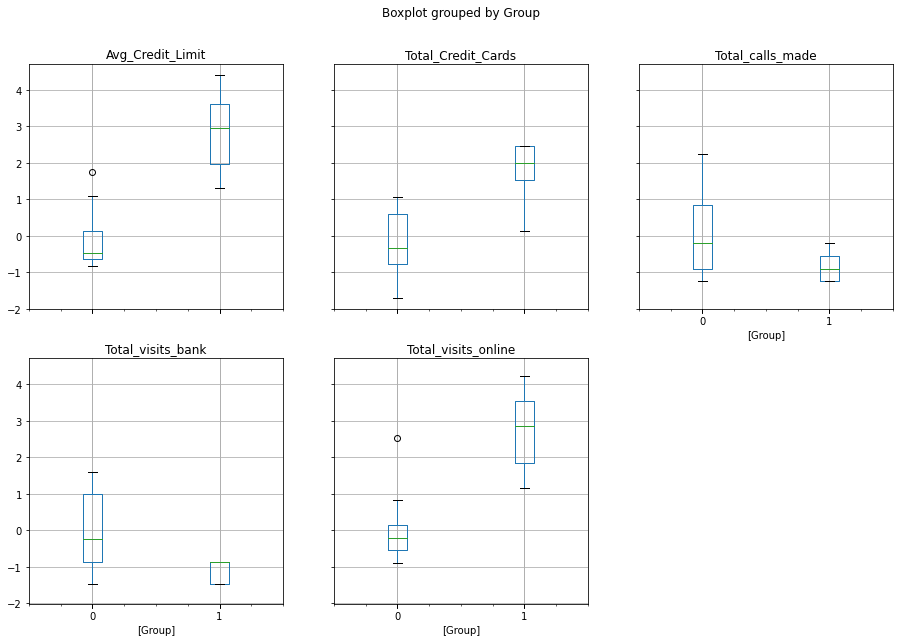

In [39]:
df_working_ScaledCustomerData["Group"] = mod_AggClust_k2.labels_
df_working_ScaledCustomerData.boxplot(by='Group', layout = (2,3),figsize=(15,10));

### Round 2 - three clusters (k=3)

In [40]:
mod_AggClust_k3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')
mod_AggClust_k3.fit(df_working_ScaledCustomerData)
df_working_CustomerData['Group'] = mod_AggClust_k3.labels_

df_set_HierCustomerData_k3 = df_working_CustomerData.groupby(['Group'])
df_set_HierCustomerData_k3.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Group                                                            
0          33713.178295            5.511628           3.485788   
1         141040.000000            8.740000           0.600000   
2          12197.309417            2.403587           0.928251   

       Total_visits_online  Total_calls_made  
Group                                         
0                 0.984496          2.005168  
1                10.900000          1.080000  
2                 3.560538          6.883408

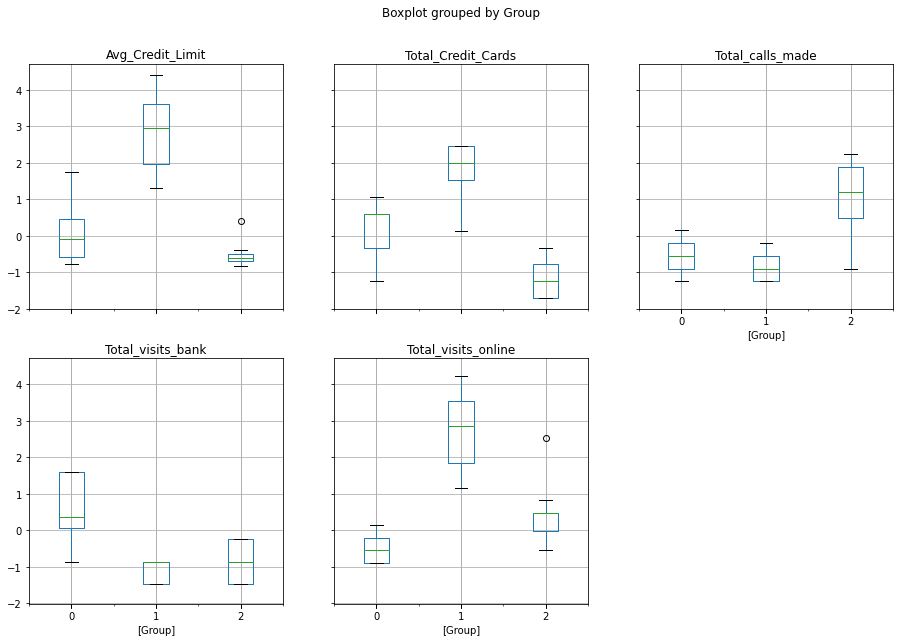

In [41]:
df_working_ScaledCustomerData["Group"] = mod_AggClust_k3.labels_
df_working_ScaledCustomerData.boxplot(by='Group', layout = (2,3),figsize=(15,10));

#### Observations

The result for three clusters (k=3) for hierarchical clustering produces a grouping that is very similar to the k=3 result for KMeans clustering. Noting that the cluster with the highest average credit limit is identical across both methods and for the two values of k tested for each one, the effect of setting k=2 in practical terms is just to merge the two clusters that form around the lower credit limits. The boxplots for k=2 show overlaps only in the bank and call centre channel choices, and given these are the two channels that should strategically be the focus for reducing query servicing times, this suggests k=2 may be a good strategy. The boxplots for three clusters as expected are almost identical to the plots for three clusters for KMeans.

### Dendogram

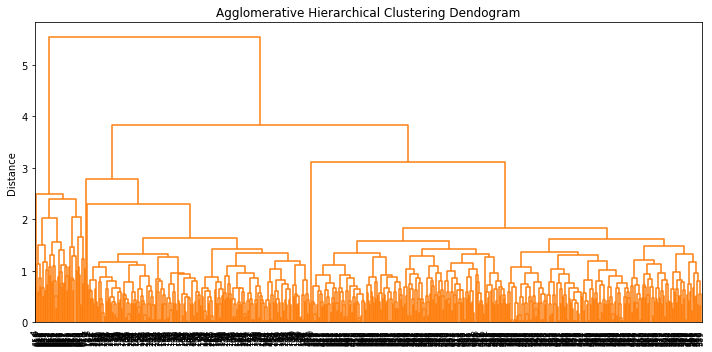

In [42]:
Z = linkage(df_working_ScaledCustomerData, metric='euclidean', method='average')

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

#### Observations

The dendogram shows that for two clusters the effect is to cluster the outliers, which is consistent wtih two of the patterns observed in the bivariate analysis - the first being that the average credit limit distribution was heavily right skewed, and the second being that preference for the online channel was highly correlated with average credit limit. This means one cluster has formed around higher credit limits and online channel preference, with the second cluster (at k=2) forming between the mean and median credit limit and with the bank and call centre channel preferences. The effect of splitting this cluster (when k=3) divides the groups by average credit limit again, with some separation around channel preference. This tends to suggest that k=2 and k=3 may BOTH be valuable, but for different business problems. The brief for this analysis was to actually solve two problems - 1) upselling and marketing, and 2) addressing perceived issues with the quality of support services - one of these speaks to understanding groupings of customers around credit usage, and the other speaks to grouping around channel usage. This is considered below.

##  
---
## Deliverable 2.3 - Comparison

*(Requirement 5. Calculate average silhouette score for both methods.)*

*(Requirement 6. Compare K-means clusters with Hierarchical clusters.)*

### KMeans Clustering Result (k = 3)

In [43]:
df_set_KMeansCustomerData_k3.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Group                                                            
0          33782.383420            5.515544           3.489637   
1          12174.107143            2.410714           0.933036   
2         141040.000000            8.740000           0.600000   

       Total_visits_online  Total_calls_made  
Group                                         
0                 0.981865          2.000000  
1                 3.553571          6.870536  
2                10.900000          1.080000

In [44]:
df_KMeansSilhouettes.head()

k  silhouette
0  3.0    0.515718
1  2.0    0.418425
2  4.0    0.355667
3  5.0    0.272641

### Hierarchical Clustering Result (k = 2)

In [45]:
df_set_HierCustomerData_k2.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Group                                                            
0          25847.540984             4.37541            2.55082   
1         141040.000000             8.74000            0.60000   

       Total_visits_online  Total_calls_made  
Group                                         
0                  1.92623          3.788525  
1                 10.90000          1.080000

In [46]:
df_HierSilhouettes.head()

k  silhouette
0  2.0    0.570318
1  3.0    0.515922
2  4.0    0.474951
3  5.0    0.440398
4  6.0    0.415355

#### Observations

Hierarchical clustering at k=2 produced the best silhouette score between the two methods at 0.5703, and hierarchical clustering also scored fractionally better at k=3 (0.5159 vs 0.5157). It is noteworthy that that hierarchical clustering at k=2 and KMeans clustering at k=3 produce an identical group at the top end of average credit limit. As was noted in the observations above, this suggests that hierarchical clustering at k=3 may actually split in a way that assists the two separate objectives for this business problem.

---
# Deliverable 3 (conclusions)
---

*(Requirement 7. Analyse the clusters formed, tell us how is one cluster different from another and
answer all the key questions.)*

In [47]:
df_set_HierCustomerData_k3.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Group                                                            
0          33713.178295            5.511628           3.485788   
1         141040.000000            8.740000           0.600000   
2          12197.309417            2.403587           0.928251   

       Total_visits_online  Total_calls_made  
Group                                         
0                 0.984496          2.005168  
1                10.900000          1.080000  
2                 3.560538          6.883408

In [48]:
df_set_HierCustomerData_k2.mean()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
Group                                                            
0          25847.540984             4.37541            2.55082   
1         141040.000000             8.74000            0.60000   

       Total_visits_online  Total_calls_made  
Group                                         
0                  1.92623          3.788525  
1                 10.90000          1.080000

Consider the 'key questions' from the problem statement in the project brief, and consider them in the context of the stated objectives to (1) target new customers as well as upsell to existing  customers, and (2) ensure  that  customers  queries  are resolved faster. Solving for objective 1 means understanding customer behaviour in terms of product usage, and solving for objective 2 means understanding customer channel usage (with the thesis being that the best way to quickly solve for answering queries faster is to shift customers away from in-person channels that are constrained in availability, and towards scalable, self-service channels that are available 24/7, like online). With this for context, the three clusters formed at k=3 will be best for objective 1 (market and upsell), and the two clusters formed at k=2 will be best for objective 2 (faster query resolution).

Returning then to the 'key questions'.

#### How many different segments of customers are there?
For targeting upselling and marketing, there are three segments of customers, which provide two clusters that could be targeted for marketing and upselling.
For targeting faster query resolution there are two segments of customers, which provide a single cluster that can be targeted for changing customer behaviour to use more self-service channels.

#### How are these segments different from each other?
The effect of hierarchical clustering is that the k=3 clusters effectively split the lower credit limit group into two - this was observed in the dendogram above. So, taking the top two groups first;

* Group 0 - average credit limit \\$25,847, hold average of 4-5 credit cards, and in the observation period made greater use of in-person channels (bank, calls) and self-service (online). Visited bank 2-3 times and made 3-4 calls, but only used online 1-2 times.
* Group 1 - average credit limit \\$141,040, hold average of 8-9 credit cards, and almost exclusively use self-service channels. Used online services 10-11 times, on average did not visit the bank (avg is less than 1), and made 1 call.

These groups differ markedly in average credit limit, and contact channel choice. The lower credit limit customers favour in-person channels, and the higher credit limit customers favour self-service.

When dividing to three clusters, Group 1 is unchanged, but Group 0 further divides as follows (group names are references to the indexes in the dataframes above);

* Group 0 - average credit limit \\$33713, hold an average of 5-6 credit cards, and in the observation period made a greater use of both in-person channels than the online channel. Visited the bank 3-4 times and made around 2 calls, versus less than 1 use of the online channel.
* Group 2 - average credit limit \\$12197, hold an average of 2-3 credit cards, and in the observation period made the highest use of the call channel, followed by the online channel.

#### What are your recommendations to the bank on how to better market to and service these customers?
Group 1, the group of customers who have the highest credit limits, would not be a target for *either* of the objectives in this campaign - on average they already have a credit limit of \\$141,040 and hold an average of 8-9 credit cards, so the opportunities to market and upsell would appear limited. Concurrently, they make the greatest use of the self-service channel, and on average do not visit bank branches and barely use the call centre, so again the opportunities to target this group for improvements to servicing time would appear limited.

Group 0 at k=2 is the group to target for improvements to query resolution time. This group made between 2-3 visits to the bank AND 3-4 calls to the call centre in the observation period, but used the online channel fewer than 2 times. This cluster should be targeted for an education, marketing, or incentive based campaign to increase the uptake of the online channel, so that more of their contacts are resolved using self-service instead of in-person contacts - this will increase the speed of query resolution simply through behaviour change.

Finally, Group 2 at k=3 is the group to target for marketing and upselling. This group only has an average credit limit of \\$12197, and hold an average of 2-3 cards, suggesting an opportunity to target this group for marketing new credit products. Of note is the strong channel preference for this group for the call centre, followed by online - this suggests a channel-based approach focussing on the call centre and online advertising (as opposed to in-branch promotions) will be the most effective in reaching these customers.